_This page is part of the material for the ["Introduction to Tensorflow"](https://indico.cism.ucl.ac.be/event/84/) session of the [2020 CISM/CÉCI trainings](http://www.ceci-hpc.be/training.html), see the [table of contents](index.html) for the other parts. The notebook can be downloaded with [this link](mlintro.ipynb)._
[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pieterdavid/cism-mltf2020/blob/main/tfprimer.ipynb)

Tensorflow is a widely used library for machine learning, especially deep learning, both training and inference (evaluating trained neural networks on new data).
It was developed by the Google Brain team, and is open source software.
On the [website](https://www.tensorflow.org) you will find many libraries and tools for common tasks related to machine learning, and a lot of training material and examples.

In this second part, we will look in a bit more detail at how [Tensorflow](https://www.tensorflow.org) works at a technical level, and why that makes it such an interesting choice.

## Fundamental classes and concepts

In the [first example](mlintro.html#A-first-example) we have used Tensorflow largely as a drop-in replacement.
That worked because it provides a lot of the same interface, and because the `Tensor` class can for many things be used just like a [numpy](https://numpy.org) array (see [this guide](https://www.tensorflow.org/guide/tensor) for some more advanced uses).

In [1]:
import tensorflow as tf
x1 = tf.linspace(0., 1., 11)
print(x1)

tf.Tensor(
[0.         0.1        0.2        0.3        0.4        0.5
 0.6        0.7        0.8        0.90000004 1.        ], shape=(11,), dtype=float32)


In fact, `Tensor` is the class used for almost everything with numerical values in Tensorflow: a single number is a 0-dimensional tensor, a list (like above) a 1-dimensional tensor, a matrix a 2-dimensional tensor etc.
To construct a `Tensor` from its value(s), the `tf.constant` helper method can be used:

In [2]:
x0 = tf.constant(3.14)
x2 = tf.constant([ [ 1., 2.], [3., 4. ] ])
print(x1)
print(x2)

tf.Tensor(
[0.         0.1        0.2        0.3        0.4        0.5
 0.6        0.7        0.8        0.90000004 1.        ], shape=(11,), dtype=float32)
tf.Tensor(
[[1. 2.]
 [3. 4.]], shape=(2, 2), dtype=float32)


As you can see above, the shape of the tensor is a tuple with the number of elements in each dimension, and the default type a 32-bit floating point number; if we were to construct one from integers, we would get a 32-bit integer type:

In [3]:
x3 = tf.constant([ 1, 1, 2, 3, 5, 8, 13, 25 ])
print(x3)

tf.Tensor([ 1  1  2  3  5  8 13 25], shape=(8,), dtype=int32)


These are all tensors with a static shape, like in numpy, but it is also possible to make tensors with dynamic shape, if the size in one dimension is not known beforehand.
This is used for input nodes, which can be constructed before the batch size is known:

In [4]:
x4 = tf.keras.layers.Input(shape=(3,))
print(x4)

Tensor("input_1:0", shape=(None, 3), dtype=float32)


It is also possible to make tensors where one dimension changes from entry to entry, and to place a `Tensor` on a GPU.

For weights in the neural network, the `Variable` class should be used, which is essentially a `Tensor` with extra functionality: the values can be stored to and loaded from a file, and it is possible to calculate derivatives with respect to a `Variable`.

### Computation graphs

There is one more important feature about tensors, and this is actually the original reason they were developed: they can be used to construct a *computation graph*, which represents the calculations that need to be done, without actually performing them.
Since Tensorflow 2.0, the default changed to use the "eager" mode, where the calculation is performed immediately, but constructing graphs (and optimizing them) provides better performance, so this is used by the higher-level helper functions to construct neural networks.

It requires a bit of setup, but we can use [Tensorboard](https://www.tensorflow.org/tensorboard) can be used to visualize such graphs (the example below is taken from [here](https://www.tensorflow.org/tensorboard/graphs#graphs_of_tffunctions) in the documentation, for an interactive version you can also view it directly there).

In [5]:
%load_ext tensorboard
# If not running on Colab, you may need to tell the extension
# where to find the tensorboard executable like this.
# To find the path: activate the conda / virtual environment,
# and run `which tensorboard`
# %env TENSORBOARD_BINARY=/home/pieter/miniconda3/envs/ceci_mltf/bin/tensorboard

env: TENSORBOARD_BINARY=/home/pieter/miniconda3/envs/ceci_mltf/bin/tensorboard


In [6]:
# 3x3 random matrics
x = tf.random.uniform((3, 3))
y = tf.random.uniform((3, 3))

@tf.function
def f1(a, b):
    return tf.nn.relu(tf.matmul(a, b))

tf.summary.trace_on(graph=True, profiler=True)
z = f1(x, y)
from datetime import datetime
logdir = f'logs/func/{datetime.now().strftime("%Y%m%d-%H%M%S")}'
with tf.summary.create_file_writer(logdir).as_default():
    tf.summary.trace_export(
        name="f1_trace_xy",
        step=0,
        profiler_outdir=logdir)

# %tensorboard --logdir logs/func ## uncomment to launch tensorboard

If everything is set up correctly, this will show the interactive version of this (alternatively, you can view it at the bottom of [this page](https://www.tensorflow.org/tensorboard/graphs#graphs_of_tffunctions))
![tensorboard screenshot](../../20201108-133809.png)

Tensorflow graphs can be optimized depending for different environments, e.g. for inference (evaluation of the neural network outupts) on mobile devices, see [this overview](https://www.tensorflow.org/guide/graph_optimization).
An additional speedup can be obtained by using the [XLA](https://www.tensorflow.org/xla) compiler, which will generate optimised computation kernels specifically for the model you use.

The `tf.function` helper function converts a python function to a Tensorflow computation graph, more details about that are given in [this guide](https://www.tensorflow.org/guide/function).

### Automatic differentiation

Computation graphs not only improve the performance when evaluating functions, they are also necessary for the automatic calculation of derivatives, or gradients.
As we saw before, training the neural net comes down to minimizing the loss function, which needs the derivatives of the loss function with respect to the network parameters.

With the loss function being, generally, of the form $L_{total} = \sum_i L(f(x_i), y_i)$, calculating the derivative with respect to a generic parameter $w$ of the neural network will require, because of the [chain rule](https://en.wikipedia.org/wiki/Chain_rule), the derivative of the network output(s) to that parameter ($j$ loops over the output nodes):
$$
\left.\frac{d\,L(f(x), y)}{d\,w}\right|_{f(x), y} = \sum_j \left.\frac{d\,L}{d\,f_j}\right|_{f_j(x), y}\cdot \left.\frac{d\,f_j}{d\,w}\right|_{x}
$$

Going back to the example of a sequential neural network, which is equivalent to a function $f(x) = f^n \circ f^{n-1} \circ \cdots \circ f^1 (x)$ (where $x$ is the list of input features, and every function maps to a list with the length of the number of output nodes in that layer, and $n$ the number of layers).
The derivate of the output node $j$ to a parameter in layer $r$ is then, by repeatedly applying the chain rule,
$$
\left.\frac{d\,f_j}{d\,w}\right|_{x} = \sum_{k_1} \sum_{k_2} \cdots \sum_{k_{n-r}}
\left.\frac{d\,f^n_j}{d\,z^1_{k_1}}\right|_{f^{n-1}(x)}\cdot
\left.\frac{d\,f^{n-1}_{k_1}}{d\,z^2_{k_2}}\right|_{f^{n-2}(x)}
\cdots
\left.\frac{d\,f^{r+1}_{k_{n-r+1}}}{d\,z^{n-r}_{k_{n-r}}}\right|_{f^{r-1}(x)}\cdot
\left.\frac{d\,f^r_{k_{n-r}}}{d\,w}\right|_{f^{r}(x)}
$$
The last factor is the derivative of the outputs of the layer where the parameter is with respect to the parameter of interest, and the remaining ones are a matrix multplication of the derivatives of each layer's outputs with respect to its inputs, that goes back from the output node to the layer before the one where our parameter is  — apologies for the heavy notation, but this makes the matrix multiplication explicit.
This way of calculating the gradient of the neural network with respect to one of its parameters is called [backpropagation](https://en.wikipedia.org/wiki/Backpropagation).
It is a very efficient way to calculate all the derivatives, since each derivative can easily be computed from the weights and the values of each node.

In fact Tensorflow implements [automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation), which generalizes backpropagation to any computer program, and we have already seen how to use that to calculate gradients in the previous example (a more detailed description can be found on [this documentation page](https://www.tensorflow.org/guide/autodiff)):

In [7]:
x = tf.Variable(3.14)
with tf.GradientTape() as tape:
    y = x**2
dydx = tape.gradient(y, x)
print(dydx.numpy())

6.28


As mentioned before, trainable parameters should be a `Variable` instances, because computation graphs can change the values of a `Variable`, but not of a `Tensor` (this allows to make a single graph for a training step, or even for the whole training of a neural network).

## Higher-level interfaces

So far we have focused on the core concepts, but for many common tasks, there are helper functions and classes in the [keras](https://keras.io) library, which is now included in Tensorflow as the `tensorflow.keras` module.
There is a wealth of documentation and examples on its website, and in the 

The core class is [`Model`](https://www.tensorflow.org/api_docs/python/tf/keras/Model), which represents a neural network, and provides a lot of useful common functionality (e.g. using predefined minimizers, splitting out a test dataset, keeping track of training and test loss).

Building a neural network of the type we have seen so far is very easy with the [sequential model](https://www.tensorflow.org/guide/keras/sequential_model): all that need to be specified is the number of nodes in each layer, the activation function, and the type of layer.
Our example from before can then be rewritten like this (output is turned off with `verbose=0`, otherwise we would get 500 lines printed with the progress of the training):

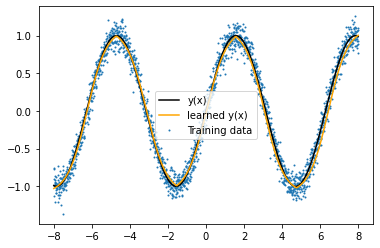

In [8]:
import tensorflow as tf
from matplotlib import pyplot as plt
x0 = tf.linspace(-8., 8., 2048)
x_learning = tf.reshape(tf.random.shuffle(x0), (2048, 1))
y_learning = ( tf.sin(x_learning)
              + tf.random.normal(x_learning.shape)*.1 )
# construct the model
nn1 = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x : .1*x),
    tf.keras.layers.Dense(128, activation="relu",
                          bias_initializer="glorot_uniform"),
    tf.keras.layers.Dense(1, activation="sigmoid"),
    tf.keras.layers.Lambda(lambda x : 2.2*x-1.1)
])
# construct graph and train
optimizer = tf.keras.optimizers.SGD(learning_rate=0.085)
nn1.compile(optimizer=optimizer, loss="mse")
nn1.fit(x_learning, y_learning, batch_size=32, epochs=250,
          validation_split=.2, verbose=0)
# plot
plt.scatter(x_learning, y_learning, label="Training data", s=1)
plt.plot(x0, tf.sin(x0), label="y(x)", color="k")
plt.plot(x0, nn1(tf.reshape(x0, (2048,1))),
         label="learned y(x)", color="orange")
plt.legend()

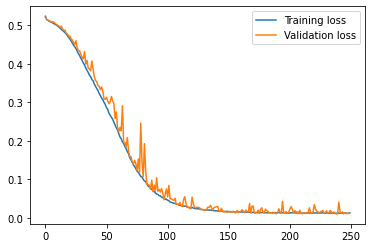

In [9]:
plt.plot(nn1.history.history["loss"], label="Training loss")
plt.plot(nn1.history.history["val_loss"], label="Validation loss")
plt.legend()

For more complex layouts, there is also the [functional API](https://www.tensorflow.org/guide/keras/functional), which allows to construct a neural network by applying functions on a set of input nodes (the `Model` is then constructed with a list of input and output nodes, and behaves the same otherwise).